In [1]:
using Distributions
using LinearAlgebra
using Random
using Roots
using StatsPlots
default(fmt=:png)

complementary_simpson_diversity_index(P) = dot(P, P)
simpson_diversity_index(P) = 1 - complementary_simpson_diversity_index(P)

function complementary_simpson_diversity_index_hat(K)
    n = float(sum(K))
    (dot(K, K) - n)/(n*(n-1))
end

simpson_diversity_index_hat(K) = 1 - complementary_simpson_diversity_index_hat(K) 

function se_csdihat(mult)
    n, P = params(mult)
    csdi = complementary_simpson_diversity_index(P)
    √max(0, 1/(n*(n-1)) * (4(n-2)*sum(p->p^3, P) - (4n-6)*csdi^2 + 2csdi))
end

multinomial(K) = Multinomial(sum(K), K/sum(K))
sehat_csdihat(K) = se_csdihat(multinomial(K))
sehat_csdihat(K, csdi) = se_csdihat(multinomial(K), csdi)

function pvalue_sdi(K, sdi)
    sdihat = simpson_diversity_index_hat(K)
    sehat = sehat_csdihat(K)
    z = (sdihat - sdi) / sehat
    2ccdf(Normal(), abs(z))
end

function confint_sdi(K, α=0.05)
    w = cquantile(Normal(), α/2)
    sdihat = simpson_diversity_index_hat(K)
    sehat = sehat_csdihat(K)
    [sdihat - w*sehat, sdihat + w*sehat]
end

function sehat_csdihat_bayes(K)
    n = sum(K)
    r = length(K)
    v1 = sum(K[i]/n * (K[i]+1)/(n+1) * (K[i]+2)/(n+2) * (K[i]+3)/(n+3) for i in 1:r)
    v2 = 2sum(K[i]/n * (K[i]+1)/(n+1) * K[j]/(n+2) * (K[j]+1)/(n+3) for i in 1:r-1 for j in i+1:r)
    v3 = -sum(K[i]/n * (K[i]+1)/(n+1) for i in 1:r)^2
    (1 + 2/(n-1)) * √(v1 + v2 + v3)
end

function pvalue_sdi_bayes(K, sdi)
    sdihat = simpson_diversity_index_hat(K)
    sehat = sehat_csdihat_bayes(K)
    z = (sdihat - sdi) / sehat
    2ccdf(Normal(), abs(z))
end

function confint_sdi_bayes(K, α=0.05)
    w = cquantile(Normal(), α/2)
    sdihat = simpson_diversity_index_hat(K)
    sehat = sehat_csdihat_bayes(K)
    [sdihat - w*sehat, sdihat + w*sehat]
end

confint_sdi_bayes (generic function with 2 methods)

In [2]:
K = [10, 6, 2, 1, 1]
mult = multinomial(K)
@show complementary_simpson_diversity_index_hat(K)
@show complementary_simpson_diversity_index(probs(mult));

complementary_simpson_diversity_index_hat(K) = 0.32105263157894737
complementary_simpson_diversity_index(probs(mult)) = 0.355


simpson_diversity_index(probs(mult)) = 0.645
mean(sdihat) = 0.6449902715789474
se_csdihat(mult) = 0.07977187870157591
std(sdihat) = 0.0797449857193434
mean(sehat) = 0.07893249536847563
se_csdihat(mult) ^ 2 = 0.006363552631578941
var(sdihat) = 0.006359262747378281
mean(sehat .^ 2) = 0.0066018132253157875


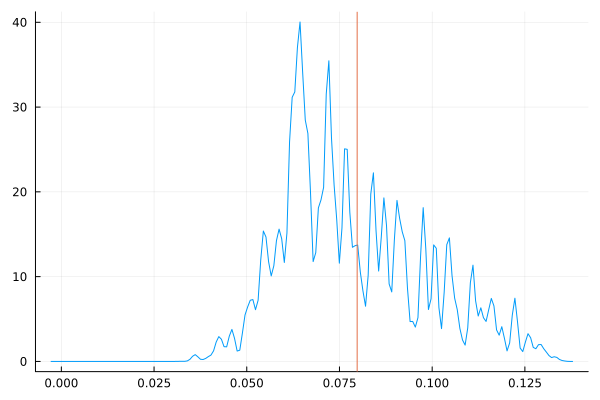

In [3]:
function sim_sdihat(mult::Multinomial; niters=10^7)
    #csdi = simpson_diversity_index(probs(mult))
    sdihat = zeros(niters)
    sehat = zeros(niters)
    Ktmp = [rand(mult) for _ in 1:Threads.nthreads()]
    Threads.@threads :static for i in 1:niters
        tid = Threads.threadid()
        K = rand!(mult, Ktmp[tid])
        sdihat[i] = simpson_diversity_index_hat(K)
        sehat[i] = sehat_csdihat(K)#, csdi)
    end
    (; sdihat, sehat)
end

mult = multinomial([10, 6, 2, 1, 1])
(; sdihat, sehat) = sim_sdihat(mult)
@show simpson_diversity_index(probs(mult))
@show mean(sdihat)
@show se_csdihat(mult)
@show std(sdihat)
@show mean(sehat)
@show se_csdihat(mult)^2
@show var(sdihat)
@show mean(sehat.^2)

density(sehat; label="")
vline!([se_csdihat(mult)]; label="")

In [4]:
function plot_pvalue_sdi(; K = [5, 5, 5, 5], α = 0.05, sdimin=0.0, sdimax=1.0)
    @show K α
    @show sdihat = simpson_diversity_index_hat(K)
    @show sehat = sehat_csdihat(K)
    @show ci = confint_sdi(K, α)
    @show ci_bayes = confint_sdi_bayes(K, α)
    plot(sdi -> pvalue_sdi(K, sdi), sdimin, sdimax; label="")
    plot!(sdi -> pvalue_sdi_bayes(K, sdi), sdimin, sdimax; label="")
    plot!(ci, fill(α+0.01, 2); label="")
    plot!(ci_bayes, fill(α-0.01, 2); label="")
end

plot_pvalue_sdi (generic function with 1 method)

K = [5, 5, 5, 5]
α = 0.05
sdihat = simpson_diversity_index_hat(K) = 0.7894736842105263
sehat = sehat_csdihat(K) = 0.031414043121877164
ci = confint_sdi(K, α) = [0.7279032910828587, 0.851044077338194]
ci_bayes = confint_sdi_bayes(K, α) = [0.7279481371167884, 0.8509992313042642]


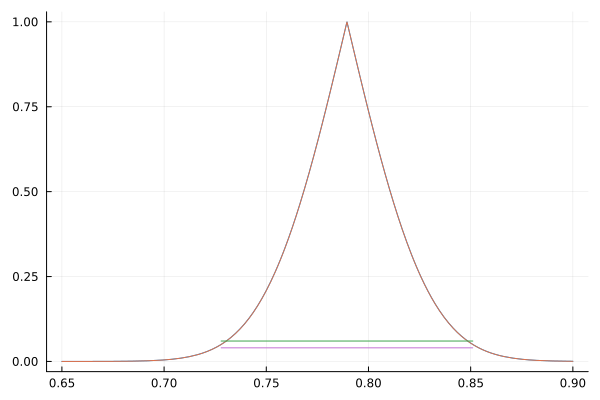

In [5]:
plot_pvalue_sdi(; K = [5, 5, 5, 5], α = 0.05, sdimin=0.65, sdimax=0.9)

K = [1, 6]
α = 0.05
sdihat = simpson_diversity_index_hat(K) = 0.2857142857142857
sehat = sehat_csdihat(K) = 0.19635519813974037
ci = confint_sdi(K, α) = [-0.09913483081683266, 0.6705634022454041]
ci_bayes = confint_sdi_bayes(K, α) = [-0.09071038566082429, 0.6621389570893956]


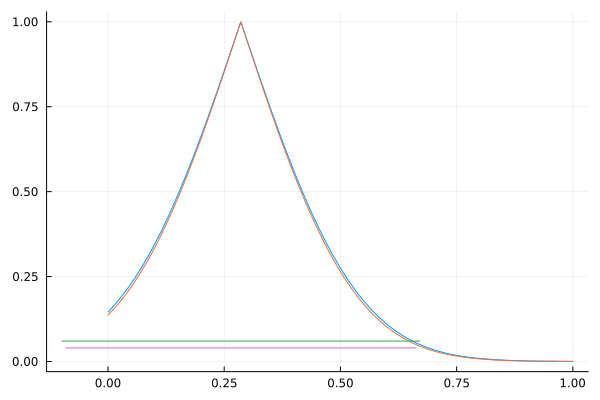

In [6]:
plot_pvalue_sdi(; K = [1, 6], α = 0.05)

K = [9, 8, 7, 6, 5, 5, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
α = 0.05
sdihat = simpson_diversity_index_hat(K) = 0.9765694076038903
sehat = sehat_csdihat(K) = 0.004722661183464467
ci = confint_sdi(K, α) = [0.9673131617731147, 0.985825653434666]
ci_bayes = confint_sdi_bayes(K, α) = [0.9671305852641672, 0.9860082299436135]


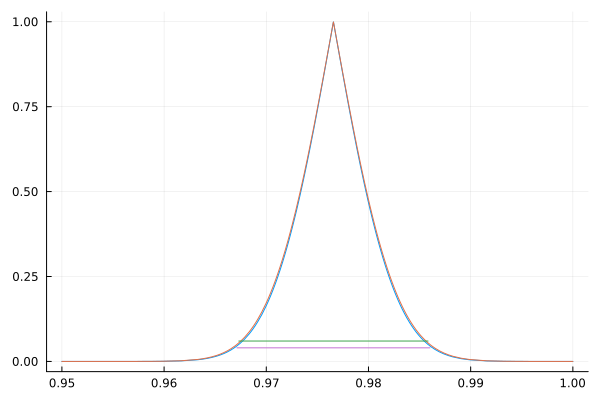

In [7]:
table1 = [9; 8; 7; 6; 5; 5; fill(4, 3); fill(3, 4); fill(2, 9); fill(1, 35)]
plot_pvalue_sdi(; K = table1, α = 0.05, sdimin=0.95)

K = [37, 5, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
α = 0.05
sdihat = simpson_diversity_index_hat(K) = 0.8956675508399646
sehat = sehat_csdihat(K) = 0.025909984869790532
ci = confint_sdi(K, α) = [0.8448849136551974, 0.9464501880247319]
ci_bayes = confint_sdi_bayes(K, α) = [0.845058875627623, 0.9462762260523062]


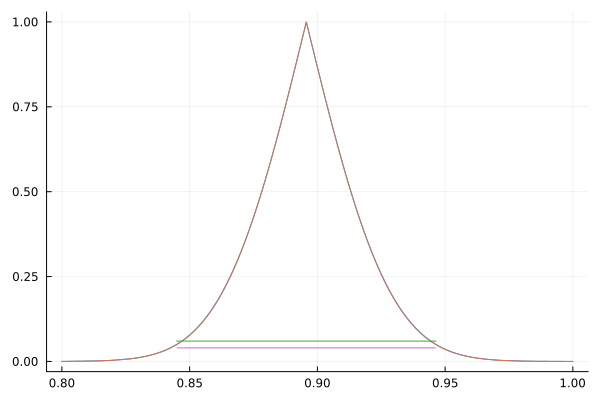

In [8]:
table2 = [37; 5; fill(4, 2); fill(3, 4); fill(2, 8); fill(1, 39)]
plot_pvalue_sdi(; K = table2, α = 0.05, sdimin=0.8)

K = [30, 13, 9, 8, 7, 7, 7, 6, 6, 5, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
α = 0.05
sdihat = simpson_diversity_index_hat(K) = 0.899351606248158
sehat = sehat_csdihat(K) = 0.017173244346535586
ci = confint_sdi(K, α) = [0.865692665831242, 0.933010546665074]
ci_bayes = confint_sdi_bayes(K, α) = [0.8657842641246648, 0.9329189483716512]


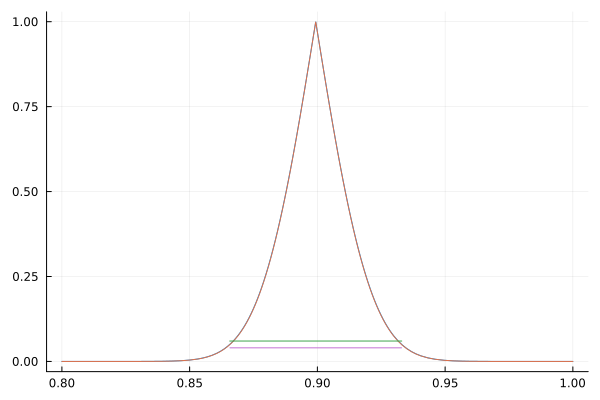

In [9]:
table3 = [30; 13; 9; 8; fill(7, 3); fill(6, 2); 5; fill(2, 3); fill(1, 13)]
plot_pvalue_sdi(; K = table3, α = 0.05, sdimin=0.8)

In [10]:
function sim_pval(mult::Multinomial, sdi=simpson_diversity_index(probs(mult)); niters=10^6)
    pval = zeros(niters)
    pval_bayes = zeros(niters)
    Ktmp = [rand(mult) for _ in 1:Threads.nthreads()]
    Threads.@threads :static for i in 1:niters
        tid = Threads.threadid()
        K = rand!(mult, Ktmp[tid])
        pval[i] = pvalue_sdi(K, sdi)
        pval_bayes[i] = pvalue_sdi_bayes(K, sdi)
    end
    (; pval, pval_bayes)
end

_ecdf(A, x) = count(≤(x), A) / length(A)

function plot_pval(mult::Multinomial, sdi=simpson_diversity_index(probs(mult)); niters=10^6)
    (; pval, pval_bayes) = sim_pval(mult, sdi; niters)
    plot(sdi -> _ecdf(pval, sdi), 0, 0.1; label="")
    plot!(sdi -> _ecdf(pval_bayes, sdi), 0, 0.1; label="")
    plot!(identity; label="", c=:gray, ls=:dot)
    plot!(size=(400, 400))
end

plot_pval (generic function with 2 methods)

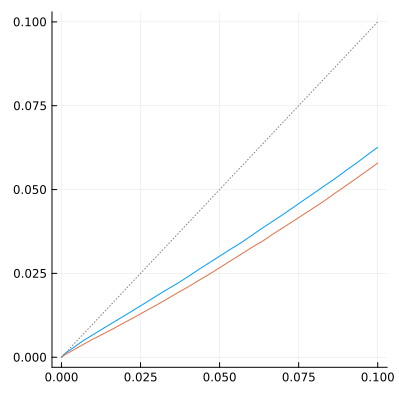

In [11]:
plot_pval(multinomial(table1))

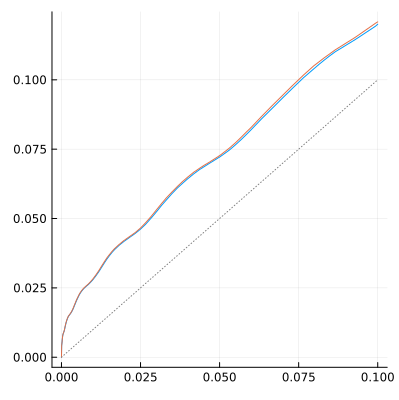

In [12]:
plot_pval(multinomial(table2))

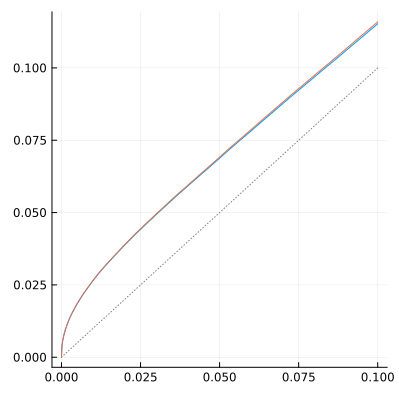

In [13]:
plot_pval(multinomial(table3))

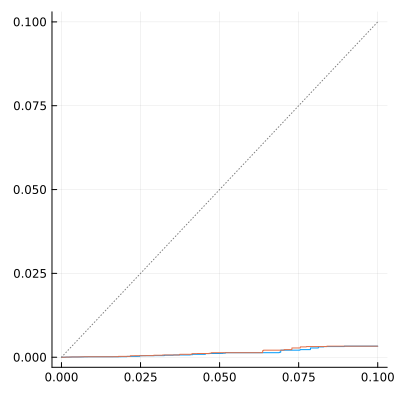

In [14]:
plot_pval(multinomial([5, 5, 5, 5]))

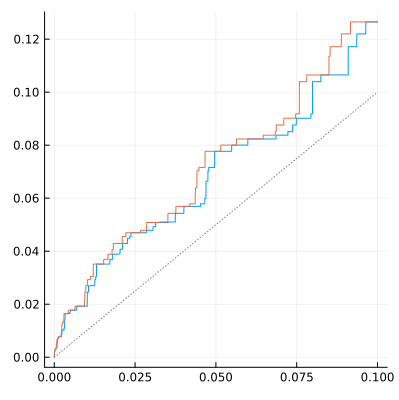

In [15]:
plot_pval(multinomial([10, 6, 2, 1, 1]))

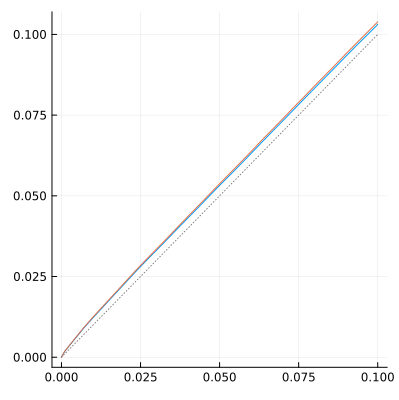

In [16]:
plot_pval(multinomial([100, 60, 20, 10, 10, 3, 3, 1, 1, 1]))